In [1]:
import pandas as pd
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
df = pd.read_csv("/content/spam.csv", encoding='ISO-8859-1')

df = df[['Category', 'Message']]

# Map 'ham' to 0 and 'spam' to 1
df['Category'] = df['Category'].map({'ham': 0, 'spam': 1})

# Train-test split (80-20 % split)
X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Category'], test_size=0.2, random_state=42)

# Tokenization using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
def encode_texts(texts, max_len=128):
    return tokenizer(
        texts.tolist(),
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf'
    )

# Encode train and test data
X_train_enc = encode_texts(X_train)
X_test_enc = encode_texts(X_test)

In [5]:
# Load pre-trained BERT model and configure for classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# Train the model
history = model.fit(
    {'input_ids': X_train_enc['input_ids'], 'attention_mask': X_train_enc['attention_mask']},
    y_train,
    epochs=3,
    batch_size=16,
    validation_data=({'input_ids': X_test_enc['input_ids'], 'attention_mask': X_test_enc['attention_mask']}, y_test)
)

Epoch 1/3
279/279 [==============================] - 171s 442ms/step - loss: 0.0819 - accuracy: 0.9753 - val_loss: 0.0342 - val_accuracy: 0.9937
Epoch 2/3
279/279 [==============================] - 123s 442ms/step - loss: 0.0207 - accuracy: 0.9946 - val_loss: 0.0236 - val_accuracy: 0.9937
Epoch 3/3
279/279 [==============================] - 134s 482ms/step - loss: 0.0058 - accuracy: 0.9987 - val_loss: 0.0295 - val_accuracy: 0.9928


In [7]:
# Evaluate the model
y_pred_logits = model.predict({'input_ids': X_test_enc['input_ids'], 'attention_mask': X_test_enc['attention_mask']})
y_pred = tf.argmax(y_pred_logits['logits'], axis=1).numpy()

# DataFrame to show true and predicted labels
results_df = pd.DataFrame({'True Labels': y_test, 'Predicted Labels': y_pred})

print("True vs Predicted Labels:")
print(results_df)

35/35 [==============================] - 12s 272ms/step
True vs Predicted Labels:
      True Labels  Predicted Labels
3245            0                 0
944             0                 0
1044            0                 0
2484            0                 0
812             0                 0
...           ...               ...
4264            0                 0
2439            0                 0
5556            0                 0
4205            0                 0
4293            0                 0

[1115 rows x 2 columns]


In [10]:
results_df[results_df['True Labels']==1]

,True Labels,Predicted Labels
14,1,1
24,1,1
40,1,1
47,1,1
51,1,1
...,...,...
1091,1,1
1094,1,1
1102,1,1
1105,1,1


In [11]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

Classification Report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       966
        spam       0.97      0.97      0.97       149

    accuracy                           0.99      1115
   macro avg       0.98      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



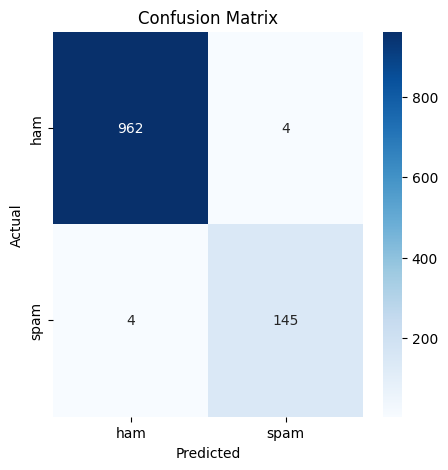

In [12]:
# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

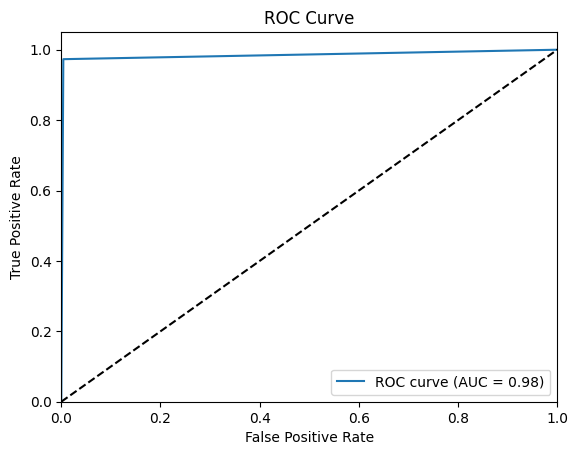

In [13]:
# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [14]:
# Precision and F1 score
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9732
F1 Score: 0.9732


In [15]:
# Final metrics summary
accuracy = (y_pred == y_test).mean()
recall = tp = conf_matrix[1, 1]  # True Positives
fn = conf_matrix[1, 0]  # False Negatives
recall = tp / (tp + fn)  # Recall calculation

print(f"\nSummary of Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Confusion Matrix:\n {conf_matrix}")
print(f"ROC AUC: {roc_auc:.4f}")


Summary of Metrics:
Accuracy: 0.9928
Recall: 0.9732
Confusion Matrix:
 [[962   4]
 [  4 145]]
ROC AUC: 0.9845
